In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

##  Loading Dataset

In [144]:
data = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/Data-Science-ML-Capstone-Projects/master/Automobile_insurance_fraud.csv")

Business case:
Insurance fraud is a huge problem in the industry. It's difficult to identify fraud claims. Machine Learning is in a unique position to help the Auto Insurance industry with this problem.

In this project, you are provided a dataset which has the details of the insurance policy along with the customer details. It also has the details of the accident on the basis of which the claims have been made. 

In this example, you will be working with some auto insurance data to demonstrate how you can create a predictive model that predicts if an insurance claim is fraudulent or not. 

In [145]:
data.shape # 1000  rows and 40 columns

(1000, 40)

In [146]:
data.head() # checking first four rows 

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [147]:
data.columns.values # checking all columns in our dataset

array(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_date', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage',
       'bodily_injuries', 'witnesses', 'police_report_available',
       'total_claim_amount', 'injury_claim', 'property_claim',
       'vehicle_claim', 'auto_make', 'auto_model', 'auto_year',
       'fraud_reported', '_c39'], dtype=object)

In [13]:
data.nunique() # Checking unique values in each column in our dataset

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

### Observations
#### 1 _c39 is not having any value and is irrelevant
#### 2 All policy_number are different and irrelevant to our model


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [148]:
# We have "policy_bind_date" column having object datatype and is storing the dates.
data['policy_bind_date'] = pd.to_datetime(data['policy_bind_date'])

In [149]:
data['policy_bind_year']=data['policy_bind_date'].dt.year # Extracting year from our date
data['policy_bind_month']=data['policy_bind_date'].dt.month # extracting month from our date
# data['policy_bind_day']=data['policy_bind_date'].dt.day

In [150]:
data = data.drop(columns = "policy_bind_date")# we don't need this column now

In [151]:
data = data.drop(columns= ["_c39", "policy_number"])# removing irrelevant columns

In [152]:
#let us label encode coulumns having only 2 values.

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            
            le.fit(data[col])
            
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

2 columns were label encoded.


<AxesSubplot:>

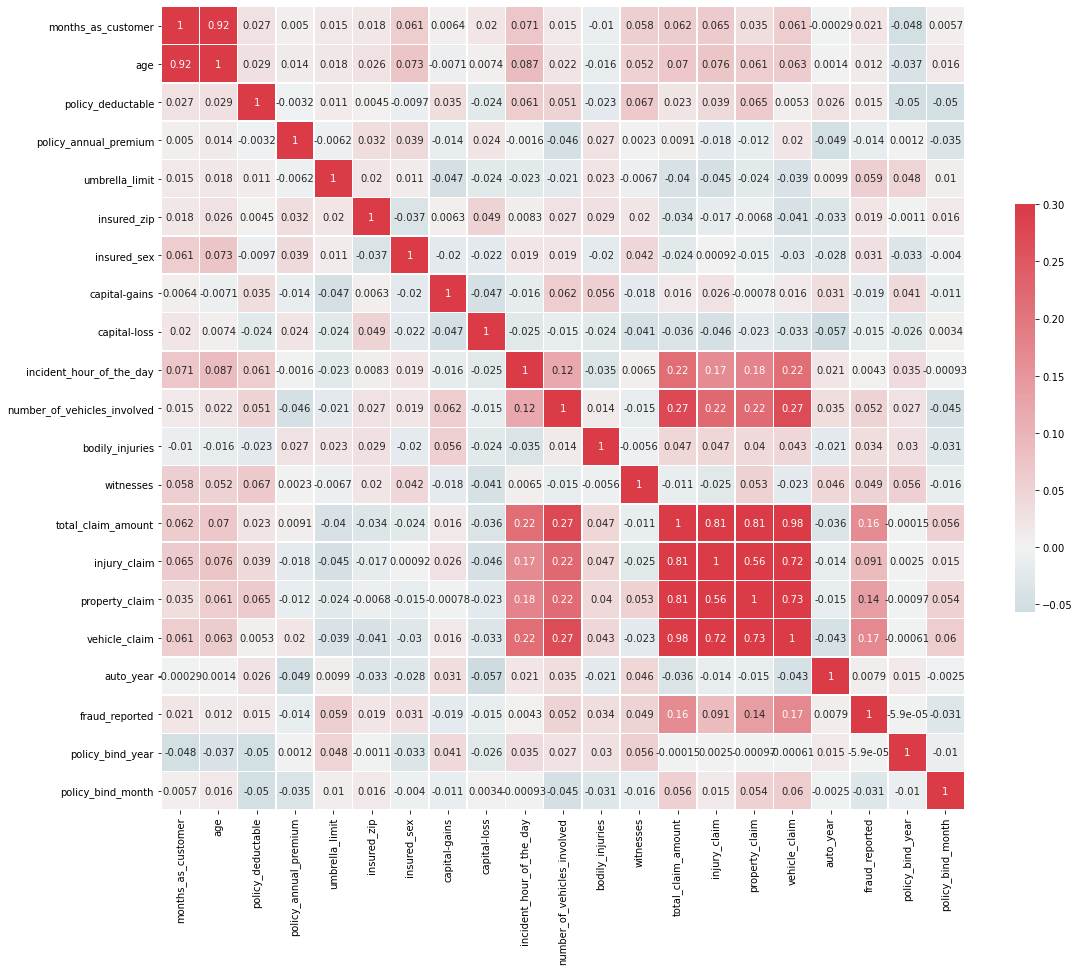

In [153]:
# Checking correlation with heatmap
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data.corr(), cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [154]:
# let us encode other categorical columns with one hot encoding
data_dummies = pd.get_dummies(data)
data_dummies.head()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,incident_hour_of_the_day,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,328,48,1000,1406.91,0,466132,1,53300,0,5,...,0,0,0,0,0,0,0,0,0,0
1,228,42,2000,1197.22,5000000,468176,1,0,0,8,...,0,0,0,0,0,0,0,0,0,0
2,134,29,2000,1413.14,5000000,430632,0,35100,0,7,...,0,1,0,0,0,0,0,0,0,0
3,256,41,2000,1415.74,6000000,608117,0,48900,-62400,5,...,0,0,0,0,0,1,0,0,0,0
4,228,44,1000,1583.91,6000000,610706,1,66000,-46000,20,...,0,0,1,0,0,0,0,0,0,0


In [155]:
#Checking class imbalance of label
data_dummies["fraud_reported"].value_counts()

0    753
1    247
Name: fraud_reported, dtype: int64

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

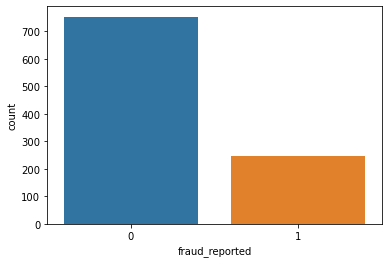

In [156]:
#Visualizing
sns.countplot(data_dummies['fraud_reported']) # Imbalanced data set

In [157]:
# Splitting our data into feature and labels
X = data_dummies.drop(columns = ['fraud_reported'], axis = 1) # features
Y = data_dummies['fraud_reported'] # Labels

In [158]:
Y

0      1
1      1
2      0
3      1
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: fraud_reported, Length: 1000, dtype: int32

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 27)

### Upsampling to deal with class imbalance

In [160]:
from sklearn.utils import resample
X = pd.concat([X_train, Y_train], axis = 1)

FY = X[X.fraud_reported ==1]
FN = X[X.fraud_reported ==0]

In [161]:
FY_upsampled = resample(FY, replace = True, n_samples = len(FN), random_state = 27) # upsampling
# FN_downsampled = resample(FN, replace = True, n_samples = len(FY), random_state = 27)

In [162]:
upsampled = pd.concat([FN, FY_upsampled])
#downsampled = pd.concat([FY, FN_downsampled])

In [163]:
upsampled.fraud_reported.value_counts()
#downsampled.fraud_reported.value_counts()

1    605
0    605
Name: fraud_reported, dtype: int64

In [164]:
X = upsampled.drop(columns = ['fraud_reported'], axis = 1)
Y = upsampled['fraud_reported']

# X = downsampled.drop(columns = ['fraud_reported'], axis = 1)
# Y = downsampled['fraud_reported']

### Scaling

In [165]:
# Min_Max Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)

###  Train-test split

In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaler, Y, train_size = 0.8, random_state = 27)

## Model building

### Logistic regression model

In [167]:
log_reg = LogisticRegression()

In [168]:
log_reg.fit(X_train, Y_train) # training our model

LogisticRegression()

In [169]:
log_reg.score(X_train, Y_train) # Training score

0.9628099173553719

In [170]:
Y_pred = log_reg.predict(X_test) # Prediction

In [171]:
log_reg.score(X_test, Y_test) # Test Score

0.8966942148760331

In [172]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("confusion:",metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.8966942148760331
confusion: [[108  18]
 [  7 109]]


### KNearest neighbors classification model

In [173]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1) #Iterating from 1 to 5 to check the best value of n_neighbors
knn.fit(X_train, Y_train) # Training our model

KNeighborsClassifier(n_neighbors=1)

In [174]:
knn.score(X_train, Y_train)

1.0

In [175]:
Y_pred = knn.predict(X_test) # Prediction

In [176]:
knn.score(X_test, Y_test)

0.8264462809917356

In [177]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("confusion:",metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.8264462809917356
confusion: [[ 93  33]
 [  9 107]]


### Decision Tree classifier

In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train) # Training the model

DecisionTreeClassifier()

In [179]:
dt.score(X_train, Y_train)

1.0

In [180]:
Y_pred = dt.predict(X_test) # Prediction

In [181]:
dt.score(X_test, Y_test)

0.9338842975206612

In [182]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("confusion:",metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.9338842975206612
confusion: [[117   9]
 [  7 109]]


### Random forest classifier

In [183]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [184]:
clf.fit(X_train, Y_train) # Training model with train data

RandomForestClassifier()

In [185]:
clf.score(X_train, Y_train)

1.0

In [186]:
Y_pred = clf.predict(X_test) # Prediction

In [187]:
clf.score(X_test, Y_test)

0.9132231404958677

In [188]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("confusion:",metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.9132231404958677
confusion: [[114  12]
 [  9 107]]


## Plotting curve

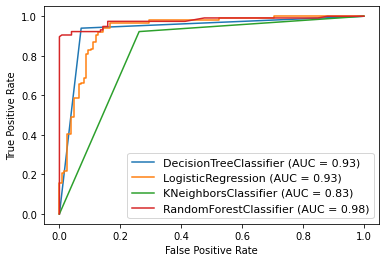

In [189]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve


disp = plot_roc_curve(dt, X_test, Y_test)
plot_roc_curve(log_reg, X_test, Y_test, ax = disp.ax_)
plot_roc_curve(knn, X_test, Y_test, ax = disp.ax_)
plot_roc_curve(clf, X_test, Y_test, ax = disp.ax_)
plt.legend(prop = {'size' : 11}, loc = 'lower right')
plt.show()

### Though accuracy for DecisionTreeClassifier is higher but area under curve of RandomForest classifier is greater and Random Forest is the best model here.
### let's apply hyperparameter tuning on this model to check whether the score improves or not

In [190]:
CLF = RandomForestClassifier()

In [216]:
params = {'n_estimators':[100,120],
         'criterion':['entropy','ginni'],
         'min_samples_split':[1,3],
         'min_samples_leaf':[1,3],
         }

grd = GridSearchCV(clf, param_grid = params)
grd.fit(X_train, Y_train)
print('best_param = >', grd.best_params_)

best_param = > {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


In [217]:
CLF = RandomForestClassifier(criterion='entropy', min_samples_leaf=1,
                       min_samples_split=3, n_estimators=100)

In [218]:
CLF.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=3)

In [219]:
CLF.score(X_train, Y_train)

1.0

In [220]:
Y_pred = CLF.predict(X_test) # Prediction

In [221]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("confusion:",metrics.confusion_matrix(Y_test, Y_pred))

Accuracy: 0.9173553719008265
confusion: [[115  11]
 [  9 107]]


### Our score slightly improves with hyperparameter tuning

## Saving Our model

In [222]:
import pickle
filename = "Insurance claim fraud detection"
pickle.dump(CLF, open(filename,'wb'))